(100, 100)


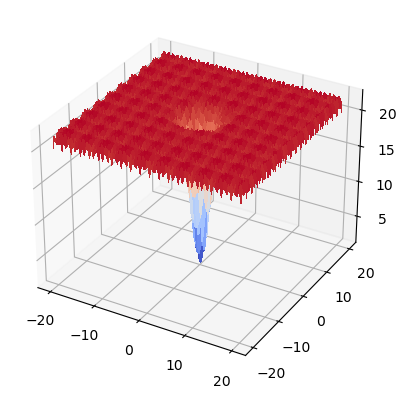

In [5]:
'''
Date: 2023-01-31 15:30:35
LastEditors: Hernando lzhen.dev@outlook.com
LastEditTime: 2023-02-04 22:25:58
FilePath: \EE6227\Homework_simulation.ipynb
'''
# This is a GA assistant for EE6227.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


# Define the function to be optimized
def f(x):  
    # x is a 2D array N by M, where N is the number of variables and M is the number of samples
    # return the function value for each sample
    N=x.shape[0]
    # return -20*np.exp(-0.2*np.sqrt(1/N*np.sum(x**2, axis=0)))-np.exp(1/N*np.sum(np.cos(2*np.pi*x), axis=0))+20+np.exp(1)
    return -20*np.exp(-0.2*np.sqrt(1/N)*np.sum(x**2, axis=0))-np.exp(1/N*np.sum(np.cos(2*np.pi*x), axis=0))+20+np.exp(1)
    # return -20*np.exp(-0.2*np.sqrt(1/N)*np.sum(x**2))-np.exp(1/N)*np.sum(np.cos(2*np.pi*x))+20+np.exp(1)


# show the function for reference
x1 = np.linspace(-20,20,100)
x2 = np.linspace(-20,20,100)

X1, X2= np.meshgrid(x1,x2)

# Z = f(np.array([X1, X2]))
Z = f(np.array([X1, X2]))
print(Z.shape)
# 3D surface plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

surf = ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# plt.show()


In [3]:
# Define the GA parameters
PopulationSize = 10
#
MAX_GENERATION = 10
# 10 bit binary Number
L = 10
N=3

from collections import deque
from datetime import time, datetime
import typing

# logger to file
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s : %(levelname)s - %(message)s',
                        filename='GA_{0}.log'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))


Search_Range=(-20,20)
# time stamp


# Gerate random Number
class GA:
    RandomNumbers = deque()
    Logger = logging.getLogger("GA")


    population = []*PopulationSize

    def init_log(self):
        # TODO: time rotation
        self.Logger.setfilename('GA_{0}.log'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))
        self.Logger.debug('Start of program')

    def __init__(self) -> None:
        self.init_log()
        # load the random Number
        RandomNumberFile="Rand_Matrics.CSV"

        with open(RandomNumberFile, 'r') as f:
            for line in f:
                self.RandomNumbers.append(int(line))
        
        self.Logger.debug("Random Number loaded")
        self.Logger.debug("Random Number size: %d", len(self.RandomNumbers))
        self.Logger.debug("Random Number: %s", self.RandomNumbers)

    def get_random_number(self)-> int:
        N=self.RandomNumbers.popleft()
        self.RandomNumbers.append(N)
        logging.debug("Random Number: Generated: %d", N)
        return N

    def scale(parent)->int:
        # scale the parent to the range of the function
        # return the scaled parent
        # parent is a 30 bit binary string

        # parent_D=int(parent, 2)
        # parent_D=parent_D/(2**N-1)*(Search_Range[1]-Search_Range[0])+Search_Range[0]

        # reshape the 30 bit binary string to 10 bit binary string
        parent_D=[]
        for i in range(0,N*L,L):
            parent_D.append(int(parent[i:i+L], 2))

        parent_D=np.array(parent_D)
        parent_D=parent_D/(2**L-1)*(Search_Range[1]-Search_Range[0])+Search_Range[0]    
        return parent_D
    
    def rev_scale(parent_D)->str:
        # convert the scaled parent_D to binary string
        # return the scaled parent
        # parent is a int
        parent=''
        for i in range(N):
            parent_D[i]=(parent_D-Search_Range[0])/(Search_Range[1]-Search_Range[0])*(2**L-1)
            parent_D[i]=int(parent_D)
            parenti=bin(parent_D)[2:]
            parenti=parent.zfill(L)
            parent=parent+parenti
        
        return parent
        
    # Define the GA operators
    def crossover(self,parent1, parent2):
        # 1 point crossover
        # parent1 and parent2 are two binary strings
        # return two children
        # TODO: check the length of the parent
        CrossoverPoint = self.get_random_number() % L
        self.Logger.debug("Crossover: CrossoverPoint: %d", CrossoverPoint)

        self.Logger.debug("Crossover: parent1: %s [%s] parent2: %s [%s]", GA.scale(parent1), parent1,GA.scale(parent2), parent2)
        child1 = parent1[:CrossoverPoint] + parent2[CrossoverPoint:]
        child2 = parent2[:CrossoverPoint] + parent1[CrossoverPoint:]
        self.Logger.debug("Crossover: child1: %s [%s] child2: %s [%s]", GA.scale(child1), child1,GA.scale(child2), child2)
        return child1, child2
    
    def mutation(child, self):
        # flip one bit in the child
        # return the mutated child
        MutationPoint = self.get_random_number() % L
        self.Logger.debug("Mutation: MutationPoint: %d", MutationPoint)
        self.Logger.debug("Mutation: child: %s [%s]", GA.scale(child), child)
        child_m=child[:MutationPoint] + str(1-int(child[MutationPoint])) + child[MutationPoint+1:]
        self.Logger.debug("Mutation: Mutated child: %s [%s]", GA.scale(child_m), child_m)
        return child_m

    
    def selection(population, self):
        # 10% will live on to the next generation
        # 50% of the best will generate 90% of the next generation
        # return the next generation

        # calculate the fitness of each individual
        fitness = self.fitness(population)
        
        # select the best 20%
        best = population[:int(PopulationSize*0.2)]
        self.Logger.debug("Selection: Best: %s", ('{0}:{1}'.format(population[i], fitness[i]) for i in best))
        ng=best
        # select the best 40%
        Parents_pool = population[:int(PopulationSize*0.4)]

        # generate 80% of the next generation
        # each parent will generate 2 children 2 times
        i=0
        while len(ng)<int(PopulationSize):
            # select parents by the order in the population
            parent1 = Parents_pool[i]
            parent2 = Parents_pool[i+1]
            i+=2
            i%=len(Parents_pool)
            # crossover
            child1, child2 = self.crossover(parent1, parent2)
            # mutation
            child1 = self.mutation(child1)
            child2 = self.mutation(child2)
            # add the children to the next generation
            ng.append(child1)
            ng.append(child2)

        self.Logger.debug("Selection: Next Generation: %s", ('{0}'.format(population[i] for i in ng)))
        return ng
        

    
    def cal_fitness(self, population):
        # calculate the fitness of each individual in the population
        # return the sorted fitness of each individual
        # the lower the fitness the better
        
        # Convert the population to the range of the function
        population = np.array([self.scale(population[i]) for i in range(PopulationSize)])

        fitness = np.zeros(PopulationSize)
        for i in range(PopulationSize):
            fitness[i] = f(population[i])
        # print the fitness of each individual
        # sort the population according to the fitness
        idx, fitness = zip(*sorted(enumerate(fitness),key=lambda x: x[1]))
        population = population[idx]

        self.Logger.debug("Fitness: %s", ('{0}:{1}'.format(population[i], fitness[i]) for i in range(PopulationSize)))
        return fitness

    def run(self):
        # initialize the population
        # population is linspace in the Search_Range
        # and convert to 10-bit binary string
        population_D = np.linspace(Search_Range[0], Search_Range[1], PopulationSize)
        self.population = [GA.rev_scale(population_D[i]) for i in range(PopulationSize)]

        self.Logger.debug("Initial Population: %s", ('{0}:{1}\n'.format(population_D[i], population[i]) for i in range(PopulationSize)))
        
        # plot the best 4 fitness by generation
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10),sharex=True,sharey=True)
        ax[0][0].set_xlim(0, MAX_GENERATION)
        
        ax[0][0].set_xlabel('Generation')
        ax[0][0].set_ylabel('Fitness')

        ax[0][0].set_title('Best')
        ax[0][1].set_title('2nd Best')
        ax[1][0].set_title('3rd Best')
        ax[1][1].set_title('4th Best')

        # run the GA
        for i in range(10):
            # print the best individual
            fitness = self.fitness(self.population)
            best = np.argmax(fitness)
            print(self.population[best], fitness[best])
            
            # plot the best 4 fitness by generation
            ax[0][0].plot(i, fitness[0], 'ro')
            ax[0][1].plot(i, fitness[1], 'ro')
            ax[1][0].plot(i, fitness[2], 'ro')
            ax[1][1].plot(i, fitness[3], 'ro')

            # select the next generation
            self.population = self.selection(self.population)


        # print the best individual
        fitness = self.fitness(self.population)
        best = np.argmax(fitness)
        print(self.population[best], fitness[best])

In [6]:
ga=GA()
ga.run()

AttributeError: 'Logger' object has no attribute 'setfilename'